In [16]:
import pathlib
import tensorflow as tf
'''
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
archive = tf.keras.utils.get_file(origin=dataset_url, extract=True)
data_dir = pathlib.Path(archive).with_suffix('')
'''

'\ndataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"\narchive = tf.keras.utils.get_file(origin=dataset_url, extract=True)\ndata_dir = pathlib.Path(archive).with_suffix(\'\')\n'

The easy way to split the image data is using the ‘split-folders’ package, which is a useful tool for automatically splitting a dataset into train, val and test sets based on the specified ratios for different subsets.

In [17]:
import splitfolders

splitfolders.ratio('./Images', output="./dogs_split_data", seed=1337, ratio=(0.7, 0.15, 0.15))

Copying files: 95 files [00:00, 486.88 files/s]

Copying files: 20580 files [00:34, 592.03 files/s]


(1) ‘splitfolders.ratio’: This is a function from the ‘split-folders’ package that performs the data splitting based on ratios.

(2) ‘./flowers’: This is the input path where the original dataset is located. In this case, the dataset is assumed to be in the “./flowers” folder.

(3) ‘output=”./flowers_split_data”’: This is the output path where the split dataset will be saved. The ‘split-folders’ package library will create three subfolders inside the output directory: “train,” “val,” and “test,” which will contain the training, validation, and test sets, respectively.

(4) ‘seed=1337’: This is an optional parameter to set the random seed, which ensures reproducibility of the split. By providing a fixed seed value (1337 in this case), you’ll get the same split every time you run the code.

(5) ‘ratio=(0.7, 0.15, 0.15)’: This is the ratio for splitting the data into train, validation, and test sets. In this case, 70% of the data will be used for training, 15% for validation, and 15% for testing.

After executing this code, you will find the split dataset in the ‘“./flowers_split_data” ‘ folder, with the appropriate distribution of images across the three subsets as specified by the ratios. This makes it easier to work with the data for training and evaluating the model separately, ensuring proper model evaluation and preventing data leakage between sets.



## Model process ##

### Step 1: Import libraries and load the dataset ###

In this step, we perform data preprocessing and augmentation. We use the ‘ImageDataGenerator’ from Keras to apply data augmentation techniques like rescaling, shear, zoom, and horizontal flip to increase the diversity of our training data. Data augmentation helps prevent overfitting and improves the generalization of the model.

Then we create data generators for the training, validation and test sets. The generators will load and preprocess images on-the-fly during training, which is memory-efficient.

In [18]:
import numpy as np
import os
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from PIL import Image

# This Code Needs to be Updated when Input Size is Changed 

# Set the path to the dataset folder
data_path = "./dogs_split_data"

# Create data generators for training and test
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255) 
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(data_path, "train"),
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    os.path.join(data_path, "val"),
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)  

# Test the model on a few samples
test_generator = val_datagen.flow_from_directory(
    os.path.join(data_path, "test"),
    target_size=(128, 128),
    batch_size=1,
    class_mode='categorical', 
    shuffle=False
)

Found 14355 images belonging to 122 classes.
Found 3025 images belonging to 122 classes.
Found 3200 images belonging to 122 classes.


### Step 2: Load the datasets and display sample images ###

In this updated code, we access the train_generator.filenames attribute to retrieve the filenames of the current batch of images. We also use the train_generator.class_indices mapping to convert the label (one-hot encoded) to its corresponding class name. The argmax() function is used to find the index of the maximum value in the one-hot encoded label, which corresponds to the class with the highest probability.

The images are displayed along with their respective filenames and training labels (class names). The batch size of 32 is used in this example, so it may show the first 32 images from the training set. You can modify the code and loop as needed to display more images.

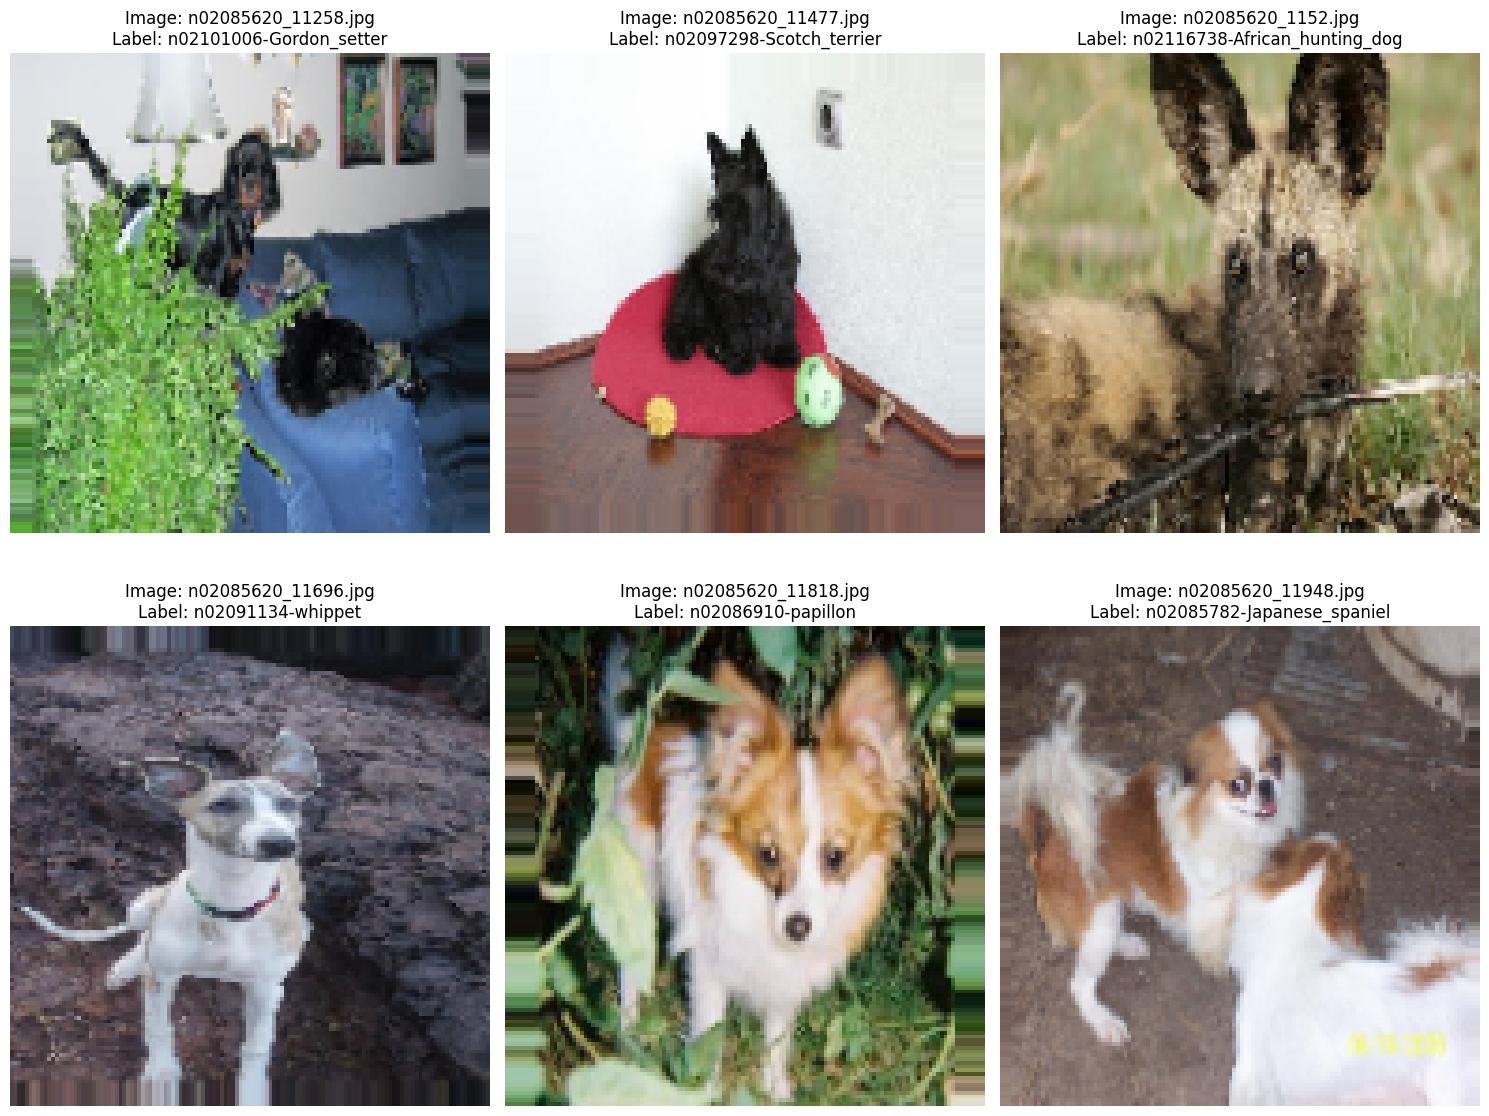

In [57]:
# Get the class indices mapping (class labels to class names)
class_indices = train_generator.class_indices

# Display 6 sample images from the training set along with their filenames and training labels
plt.figure(figsize=(15, 12))
for i in range(6):
    img, label = train_generator.next()
    img_filename = train_generator.filenames[train_generator.batch_index - 1]  # Get the filename of the current image
    img_class = list(class_indices.keys())[list(class_indices.values()).index(label[0].argmax())]  # Get the class name
    plt.subplot(2, 3, i + 1)
    plt.imshow(img[0])
    plt.title(f"Image: {os.path.basename(img_filename)}\nLabel: {img_class}")
    plt.axis('off')

plt.tight_layout()
plt.show()

### Step 3: Build the CNN model ###

In [58]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    tf.config.experimental.set_visible_devices(gpu_devices[0], 'GPU')

Num GPUs Available:  0


In [67]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.models import Sequential

model = Sequential()

model.add(Conv2D(16, (3, 3), activation="relu", input_shape=(128, 128, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # Output shape should be [batch_size, 4096] for 128x128 images

model.add(Dense(units=122, activation="softmax"))  # Adjust units to 120 for 120 classes

# Compile the model
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])


In [68]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 126, 126, 16)      448       
                                                                 
 batch_normalization_36 (Ba  (None, 126, 126, 16)      64        
 tchNormalization)                                               
                                                                 
 max_pooling2d_36 (MaxPooli  (None, 63, 63, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_37 (Conv2D)          (None, 61, 61, 32)        4640      
                                                                 
 batch_normalization_37 (Ba  (None, 61, 61, 32)        128       
 tchNormalization)                                               
                                                     

### Install *pydot* and *graphviz* ###

After building the model, we use ‘plot_model’ to generate the model architecture graph. We import ‘plot_model’ from Keras’ ‘utils’ module. The ‘to_file’ argument specifies the filename where the graph will be saved (in this case, as “model_architecture.png”). The ‘show_shapes=True’ and ‘show_layer_names=True’ arguments ensure that the shapes of each layer and their names are displayed in the graph.



In [69]:
##!pip install pydot
##!pip install graphviz

from keras.utils import plot_model

plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


After running this code, you should also find a file named “model_architecture.png” in the working directory, which contains the visualization of the model architecture graph. This graph will help you gain insights into the model’s structure and the flow of data through different layers.

!pip install visualkeras

import visualkeras
visualkeras.layered_view(model)

### Step 5: Train the model and save the best model based on validation accuracy ###

We train the CNN model using the data generators we created earlier. We specify the number of steps per epoch and the number of epochs for training. The ‘ModelCheckpoint’ callback allows you to save the best model during the training process based on a specified validation metric, which in this case is the validation accuracy.The ‘model.fit’ function performs the training process and stores the training history in the history variable.

In [71]:
from keras.callbacks import ReduceLROnPlateau
# Define a checkpoint to save the best model
checkpoint = ModelCheckpoint("best_cnn_flower_model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Define a learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7, verbose=1)

# Train the model with the learning rate scheduler callback
history = model.fit(
    train_generator,
    epochs=20,  # Increase the number of epochs
    validation_data=val_generator,
    callbacks=[checkpoint, lr_scheduler]
)

Epoch 1/20
449/449 [==============================] - ETA: 0s - loss: 5.0228 - accuracy: 0.0490
Epoch 1: val_accuracy improved from -inf to 0.04661, saving model to best_cnn_flower_model.h5
449/449 [==============================] - 229s 511ms/step - loss: 5.0228 - accuracy: 0.0490 - val_loss: 4.8320 - val_accuracy: 0.0466 - lr: 1.0000e-04
Epoch 2/20


c:\Users\aaron\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


449/449 [==============================] - ETA: 0s - loss: 4.5065 - accuracy: 0.0795
Epoch 2: val_accuracy improved from 0.04661 to 0.06446, saving model to best_cnn_flower_model.h5
449/449 [==============================] - 184s 409ms/step - loss: 4.5065 - accuracy: 0.0795 - val_loss: 4.9969 - val_accuracy: 0.0645 - lr: 1.0000e-04
Epoch 3/20
449/449 [==============================] - ETA: 0s - loss: 4.2403 - accuracy: 0.1117
Epoch 3: val_accuracy improved from 0.06446 to 0.07570, saving model to best_cnn_flower_model.h5

Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
449/449 [==============================] - 208s 462ms/step - loss: 4.2403 - accuracy: 0.1117 - val_loss: 4.9077 - val_accuracy: 0.0757 - lr: 1.0000e-04
Epoch 4/20
449/449 [==============================] - ETA: 0s - loss: 3.8084 - accuracy: 0.1593
Epoch 4: val_accuracy improved from 0.07570 to 0.08595, saving model to best_cnn_flower_model.h5
449/449 [==============================] - 190s 422

### Step 6: Plot the training and validation loss and accuracy to visualize the training progress ###
Plot the training and validation loss as well as the training and validation accuracy of a CNN model during the training process. This visualization is crucial for understanding the model’s performance and monitoring its training progress.

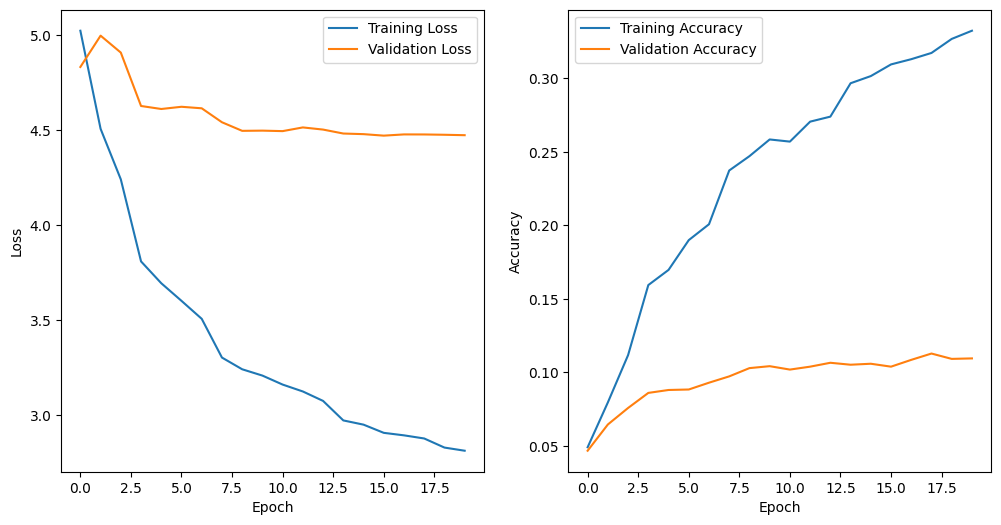

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


By plotting these graphs, you can gain valuable insights into the training process and make informed decisions regarding model architecture, hyperparameter tuning, and early stopping, ensuring the best performance for your CNN model on the flower recognition task.

### Step 7: Test the model on the test set and display some sample images ###
Load the best model based on the validation accuracy saved during training using the ModelCheckpoint. We then use the test data generator to get the test samples and display some sample images along with their true and predicted labels.

   1/3200 [..............................] - ETA: 10:14

3200/3200 [==============================] - 34s 11ms/step


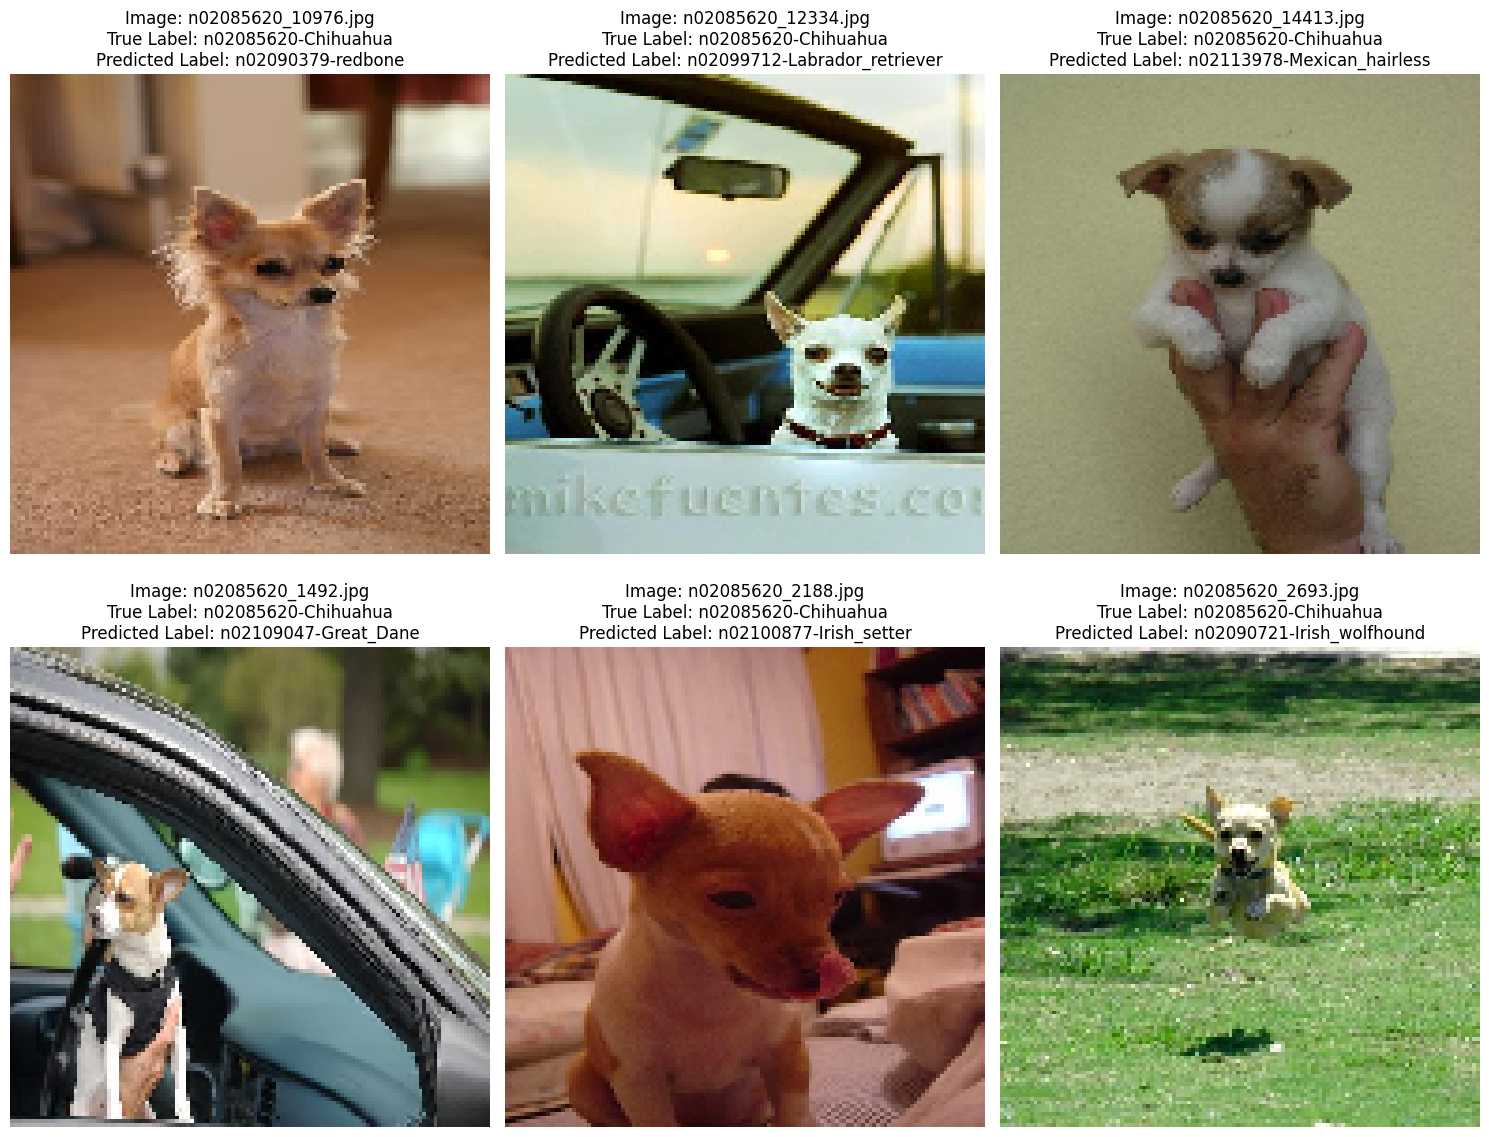

In [ ]:
# Predict on the test set
predictions = model.predict(test_generator)

# Display some sample images from the test set along with their true and predicted labels
plt.figure(figsize=(15, 12))
for i in range(6):
    img, true_label = test_generator.next()
    img_filename = test_generator.filenames[test_generator.batch_index - 1]  # Get the filename of the current image
    true_class = list(test_generator.class_indices.keys())[list(test_generator.class_indices.values()).index(true_label.argmax())]  # Get the true class name
    predicted_class = list(test_generator.class_indices.keys())[list(test_generator.class_indices.values()).index(predictions[i].argmax())]  # Get the predicted class name

    plt.subplot(2, 3, i + 1)
    plt.imshow(img[0])
    plt.title(f"Image: {os.path.basename(img_filename)}\nTrue Label: {true_class}\nPredicted Label: {predicted_class}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In this final step, we load the best model based on the validation accuracy saved during training using the ModelCheckpoint. We then use the test data generator to get the test samples and display some sample images along with their true and predicted labels.

Now, the code is complete with model building, training, evaluation, and testing. The plot of training and validation loss and accuracy helps us analyze the training progress, and the sample images give us a visual representation of the model’s performance on the test set. From the results, we can see the model detection performance still needs to improve.

### Step 8: Evaluate the model on the test set ###
To evaluate the trained CNN model on the test set and obtain the test loss and accuracy, we can use the ‘test_generator’ created with ‘ImageDataGenerator’.

In [74]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

  83/3200 [..............................] - ETA: 35s - loss: 4.4003 - accuracy: 0.1084

3200/3200 [==============================] - 982s 307ms/step - loss: 4.4892 - accuracy: 0.1088
Test Loss: 4.4892
Test Accuracy: 0.1088


After loading trained model and the best weights using load_weights, we use evaluate to obtain the test loss and accuracy. These values are printed to the console. The evaluation results show that the prediction accuracy is only 74.64%.

In [144]:
from keras.models import load_model
import tensorflow as tf

img_height=128
img_width=128

# Load the best model saved during training
model = load_model("./best_cnn_flower_model.h5")

# Direct link to the image file
img_url = "https://raw.githubusercontent.com/Ishasharmax/FlowerClassificationCNN/main/flowersData/dandelion/130733200_fbe28eea19.jpg"
# Download the image and get the local path
img_path = tf.keras.utils.get_file('130733200_fbe28eea19.jpg', origin=img_url)

img = tf.keras.utils.load_img(
    img_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)

# Now, you can pass this 'image' to the model for prediction:
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

class_names = ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Tzu', 'Blenheim_spaniel', 'papillon', 'toy_terrier', 'Rhodesian_ridgeback', 'Afghan_hound', 'basset', 'beagle', 'bloodhound', 'bluetick', 'tan_coonhound', 'Walker_hound', 'English_foxhound', 'redbone', 'borzoi', 'Irish_wolfhound', 'Italian_greyhound', 'whippet', 'Ibizan_hound', 'Norwegian_elkhound', 'otterhound', 'Saluki', 'Scottish_deerhound', 'Weimaraner', 'Staffordshire_bullterrier', 'American_Staffordshire_terrier', 'Bedlington_terrier', 'Border_terrier', 'Kerry_blue_terrier', 'Irish_terrier', 'Norfolk_terrier', 'Norwich_terrier', 'Yorkshire_terrier', 'haired_fox_terrier', 'Lakeland_terrier', 'Sealyham_terrier', 'Airedale', 'cairn', 'Australian_terrier', 'Dandie_Dinmont', 'Boston_bull', 'miniature_schnauzer', 'giant_schnauzer', 'standard_schnauzer', 'Scotch_terrier', 'Tibetan_terrier', 'silky_terrier', 'coated_wheaten_terrier', 'West_Highland_white_terrier', 'Lhasa', 'coated_retriever', 'coated_retriever', 'golden_retriever', 'Labrador_retriever', 'Chesapeake_Bay_retriever', 'haired_pointer', 'vizsla', 'English_setter', 'Irish_setter', 'Gordon_setter', 'Brittany_spaniel', 'clumber', 'English_springer', 'Welsh_springer_spaniel', 'cocker_spaniel', 'Sussex_spaniel', 'Irish_water_spaniel', 'kuvasz', 'schipperke', 'groenendael', 'malinois', 'briard', 'kelpie', 'komondor', 'Old_English_sheepdog', 'Shetland_sheepdog', 'collie', 'Border_collie', 'Bouvier_des_Flandres', 'Rottweiler', 'German_shepherd', 'Doberman', 'miniature_pinscher', 'Greater_Swiss_Mountain_dog', 'Bernese_mountain_dog', 'Appenzeller', 'EntleBucher', 'boxer', 'bull_mastiff', 'Tibetan_mastiff', 'French_bulldog', 'Great_Dane', 'Saint_Bernard', 'Eskimo_dog', 'malamute', 'Siberian_husky', 'affenpinscher', 'basenji', 'pug', 'Leonberg', 'Newfoundland', 'Great_Pyrenees', 'Samoyed', 'Pomeranian', 'chow', 'keeshond', 'Brabancon_griffon', 'Pembroke', 'Cardigan', 'toy_poodle', 'miniature_poodle', 'standard_poodle', 'Mexican_hairless', 'dingo', 'dhole', 'African_hunting_dog']

print(f"Predicted Label: {class_names[np.argmax(score)]}")
print(f"Percent Confidence: {100 * np.max(score):.2f}%")

1/1 [==============================] - 0s 30ms/step
Predicted Label: basset
Percent Confidence: 2.20%


### Step 9: Model deployment ###

Model deployment is a critical step in the machine learning lifecycle, as it allows the model to be utilized in real-world scenarios and provide value to end-users. Proper deployment practices help deliver the benefits of machine learning and artificial intelligence to a wide range of applications and industries.

Model deployment refers to the process of making a trained machine learning model available for use in production environments. In other words, it involves taking a trained model that has been developed and tested and making it accessible for making predictions or inferences on new data. In this section here, we only show how to use the saved model to recognize a new image.

### (1) Image online ###
Sometime we will recognize an image from an online source. Here are an example:



In [145]:
from keras.models import load_model
import tensorflow as tf

img_height=128
img_width=128

# Load the best model saved during training
model = load_model("./best_cnn_flower_model.h5")

# Direct link to the image file
img_url = "https://raw.githubusercontent.com/Ishasharmax/FlowerClassificationCNN/main/flowersData/dandelion/130733200_fbe28eea19.jpg"
# Download the image and get the local path
img_path = tf.keras.utils.get_file('130733200_fbe28eea19.jpg', origin=img_url)

img = tf.keras.utils.load_img(
    img_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)

# Now, you can pass this 'image' to the model for prediction:
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

class_names = ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Tzu', 'Blenheim_spaniel', 'papillon', 'toy_terrier', 'Rhodesian_ridgeback', 'Afghan_hound', 'basset', 'beagle', 'bloodhound', 'bluetick', 'tan_coonhound', 'Walker_hound', 'English_foxhound', 'redbone', 'borzoi', 'Irish_wolfhound', 'Italian_greyhound', 'whippet', 'Ibizan_hound', 'Norwegian_elkhound', 'otterhound', 'Saluki', 'Scottish_deerhound', 'Weimaraner', 'Staffordshire_bullterrier', 'American_Staffordshire_terrier', 'Bedlington_terrier', 'Border_terrier', 'Kerry_blue_terrier', 'Irish_terrier', 'Norfolk_terrier', 'Norwich_terrier', 'Yorkshire_terrier', 'haired_fox_terrier', 'Lakeland_terrier', 'Sealyham_terrier', 'Airedale', 'cairn', 'Australian_terrier', 'Dandie_Dinmont', 'Boston_bull', 'miniature_schnauzer', 'giant_schnauzer', 'standard_schnauzer', 'Scotch_terrier', 'Tibetan_terrier', 'silky_terrier', 'coated_wheaten_terrier', 'West_Highland_white_terrier', 'Lhasa', 'coated_retriever', 'coated_retriever', 'golden_retriever', 'Labrador_retriever', 'Chesapeake_Bay_retriever', 'haired_pointer', 'vizsla', 'English_setter', 'Irish_setter', 'Gordon_setter', 'Brittany_spaniel', 'clumber', 'English_springer', 'Welsh_springer_spaniel', 'cocker_spaniel', 'Sussex_spaniel', 'Irish_water_spaniel', 'kuvasz', 'schipperke', 'groenendael', 'malinois', 'briard', 'kelpie', 'komondor', 'Old_English_sheepdog', 'Shetland_sheepdog', 'collie', 'Border_collie', 'Bouvier_des_Flandres', 'Rottweiler', 'German_shepherd', 'Doberman', 'miniature_pinscher', 'Greater_Swiss_Mountain_dog', 'Bernese_mountain_dog', 'Appenzeller', 'EntleBucher', 'boxer', 'bull_mastiff', 'Tibetan_mastiff', 'French_bulldog', 'Great_Dane', 'Saint_Bernard', 'Eskimo_dog', 'malamute', 'Siberian_husky', 'affenpinscher', 'basenji', 'pug', 'Leonberg', 'Newfoundland', 'Great_Pyrenees', 'Samoyed', 'Pomeranian', 'chow', 'keeshond', 'Brabancon_griffon', 'Pembroke', 'Cardigan', 'toy_poodle', 'miniature_poodle', 'standard_poodle', 'Mexican_hairless', 'dingo', 'dhole', 'African_hunting_dog']

print(f"Predicted Label: {class_names[np.argmax(score)]}")
print(f"Percent Confidence: {100 * np.max(score):.2f}%")

1/1 [==============================] - 0s 27ms/step
Predicted Label: basset
Percent Confidence: 2.20%


In the above code, we loads and preprocess an image using TensorFlow and making a prediction with the trained model. It correctly loads the image from a URL, resizes it to the desired dimensions, converts it to a NumPy array, and adds a batch dimension.

Here’s a summary of the steps:

* Load the best model saved during training using ‘load_model()’ from Keras.
* Download an image from a URL using ‘tf.keras.utils.get_file()’. The ‘origin’ argument should be the URL of the image you want to download.
* Load and preprocess the image using ‘tf.keras.utils.load_img()’ and ‘tf.keras.utils.img_to_array()’.
* Add a batch dimension to the image using ‘tf.expand_dims()’ to match the expected input shape of the model.
* Make predictions using the ‘model.predict()’ method.
* Apply ‘tf.nn.softmax()’ function to the predicted scores. This function converts the scores into probabilities, representing the confidence of the model’s predictions.
* Use the ‘np.argmax(score)’ function to find the index of the class with the highest probability (the predicted label), and ‘class_names[np.argmax(score)]’ retrieves the corresponding class name list [‘daisy’, ‘dandelion’, ‘rose’, ‘sunflower’, ‘tulip’].
* Calculate the percent confidence of the predicted class using ‘100 * np.max(score)’ , and format the value to two decimal places using ‘:.2f’ in the print statement.

### (2) Local drive ###
Most of time, the images are stored in the local drives. In this case, we just need to get the local path of image to be predicted.

In [146]:
import numpy as np
import tensorflow as tf
from keras.models import load_model

img_height = 128
img_width = 128

# Load the best model saved during training
model = load_model("./best_cnn_flower_model.h5")

# Load and preprocess the image
image_path = "./Images/n02088094-Afghan_hound/n02088094_1882.jpg"

img = tf.keras.utils.load_img(
    image_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

class_names = ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Tzu', 'Blenheim_spaniel', 'papillon', 'toy_terrier', 'Rhodesian_ridgeback', 'Afghan_hound', 'basset', 'beagle', 'bloodhound', 'bluetick', 'tan_coonhound', 'Walker_hound', 'English_foxhound', 'redbone', 'borzoi', 'Irish_wolfhound', 'Italian_greyhound', 'whippet', 'Ibizan_hound', 'Norwegian_elkhound', 'otterhound', 'Saluki', 'Scottish_deerhound', 'Weimaraner', 'Staffordshire_bullterrier', 'American_Staffordshire_terrier', 'Bedlington_terrier', 'Border_terrier', 'Kerry_blue_terrier', 'Irish_terrier', 'Norfolk_terrier', 'Norwich_terrier', 'Yorkshire_terrier', 'haired_fox_terrier', 'Lakeland_terrier', 'Sealyham_terrier', 'Airedale', 'cairn', 'Australian_terrier', 'Dandie_Dinmont', 'Boston_bull', 'miniature_schnauzer', 'giant_schnauzer', 'standard_schnauzer', 'Scotch_terrier', 'Tibetan_terrier', 'silky_terrier', 'coated_wheaten_terrier', 'West_Highland_white_terrier', 'Lhasa', 'coated_retriever', 'coated_retriever', 'golden_retriever', 'Labrador_retriever', 'Chesapeake_Bay_retriever', 'haired_pointer', 'vizsla', 'English_setter', 'Irish_setter', 'Gordon_setter', 'Brittany_spaniel', 'clumber', 'English_springer', 'Welsh_springer_spaniel', 'cocker_spaniel', 'Sussex_spaniel', 'Irish_water_spaniel', 'kuvasz', 'schipperke', 'groenendael', 'malinois', 'briard', 'kelpie', 'komondor', 'Old_English_sheepdog', 'Shetland_sheepdog', 'collie', 'Border_collie', 'Bouvier_des_Flandres', 'Rottweiler', 'German_shepherd', 'Doberman', 'miniature_pinscher', 'Greater_Swiss_Mountain_dog', 'Bernese_mountain_dog', 'Appenzeller', 'EntleBucher', 'boxer', 'bull_mastiff', 'Tibetan_mastiff', 'French_bulldog', 'Great_Dane', 'Saint_Bernard', 'Eskimo_dog', 'malamute', 'Siberian_husky', 'affenpinscher', 'basenji', 'pug', 'Leonberg', 'Newfoundland', 'Great_Pyrenees', 'Samoyed', 'Pomeranian', 'chow', 'keeshond', 'Brabancon_griffon', 'Pembroke', 'Cardigan', 'toy_poodle', 'miniature_poodle', 'standard_poodle', 'Mexican_hairless', 'dingo', 'dhole', 'African_hunting_dog']

print(
    "This image most likely belongs to {} with a {:.2f} % confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
print(np.argmax(score))

1/1 [==============================] - 0s 119ms/step
This image most likely belongs to Leonberg with a 2.20 % confidence.
103


## Get Classification Names ##

In [142]:
import os

# Specify the directory containing the folders
directory_path = ".\Images"

# Check if the directory exists
if not os.path.exists(directory_path):
    print(f"The directory '{directory_path}' does not exist.")
else:
    # List all items (files and folders) in the directory
    items = os.listdir(directory_path)

    # Filter only the folders (subdirectories)
    subdirectories = [item for item in items if os.path.isdir(os.path.join(directory_path, item))]

    # Extract and print the folder names
    for folder in subdirectories:
        folder_name = folder.split("-")[-1]
        print(f"'{folder_name}',")


'Chihuahua',
'Japanese_spaniel',
'Maltese_dog',
'Pekinese',
'Tzu',
'Blenheim_spaniel',
'papillon',
'toy_terrier',
'Rhodesian_ridgeback',
'Afghan_hound',
'basset',
'beagle',
'bloodhound',
'bluetick',
'tan_coonhound',
'Walker_hound',
'English_foxhound',
'redbone',
'borzoi',
'Irish_wolfhound',
'Italian_greyhound',
'whippet',
'Ibizan_hound',
'Norwegian_elkhound',
'otterhound',
'Saluki',
'Scottish_deerhound',
'Weimaraner',
'Staffordshire_bullterrier',
'American_Staffordshire_terrier',
'Bedlington_terrier',
'Border_terrier',
'Kerry_blue_terrier',
'Irish_terrier',
'Norfolk_terrier',
'Norwich_terrier',
'Yorkshire_terrier',
'haired_fox_terrier',
'Lakeland_terrier',
'Sealyham_terrier',
'Airedale',
'cairn',
'Australian_terrier',
'Dandie_Dinmont',
'Boston_bull',
'miniature_schnauzer',
'giant_schnauzer',
'standard_schnauzer',
'Scotch_terrier',
'Tibetan_terrier',
'silky_terrier',
'coated_wheaten_terrier',
'West_Highland_white_terrier',
'Lhasa',
'coated_retriever',
'coated_retriever',
'golden_retriev